In [7]:
import numpy as np
import pandas as pd
import os
import yaml
import datetime

In [8]:
ENV_FILE='../env.yaml'
with open(ENV_FILE) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

#initialisation des chemins vers les fichiers
ROOT_DIR = os.path.dirname(os.path.abspath(ENV_FILE))
DATA_FILE= os.path.join(ROOT_DIR, params['directories']['processed'], params['files']['all_data'])

#Lecture du fihcier de données
epidemie_df = (pd.read_csv(DATA_FILE, parse_dates=['Last Update'])
               .assign(day=lambda _df:_df['Last Update'].dt.date)
               .drop_duplicates(subset=['Country/Region', 'Province/State', 'day'])
               [lambda df: df['day'] <= datetime.date(2020,3,12)]
              )

In [9]:
epidemie_df.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,source,day
0,Anhui,Mainland China,2020-01-22 17:00:00,1.0,NaN,NaN,31.8257,117.2264,01-22-2020.csv,2020-01-22
1,Beijing,Mainland China,2020-01-22 17:00:00,14.0,NaN,NaN,40.1824,116.4142,01-22-2020.csv,2020-01-22
2,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,NaN,NaN,30.0572,107.8740,01-22-2020.csv,2020-01-22
3,Fujian,Mainland China,2020-01-22 17:00:00,1.0,NaN,NaN,26.0789,117.9874,01-22-2020.csv,2020-01-22
4,Gansu,Mainland China,2020-01-22 17:00:00,NaN,NaN,NaN,36.0611,103.8343,01-22-2020.csv,2020-01-22


In [10]:
france_df = (epidemie_df[epidemie_df['Country/Region']=='France']
             .groupby(['Country/Region','day'])
             .agg({'Confirmed':'sum', 'Deaths':'sum', 'Recovered':'sum'})
             .reset_index()
            )

france_df.head()

,Country/Region,day,Confirmed,Deaths,Recovered
0,France,2020-01-24,2.0,0.0,0.0
1,France,2020-01-25,3.0,0.0,0.0
2,France,2020-01-26,3.0,0.0,0.0
3,France,2020-01-27,3.0,0.0,0.0
4,France,2020-01-28,4.0,0.0,0.0


In [11]:
france_df.tail()

,Country/Region,day,Confirmed,Deaths,Recovered
23,France,2020-03-07,949.0,11.0,12.0
24,France,2020-03-08,1126.0,19.0,12.0
25,France,2020-03-09,1209.0,19.0,12.0
26,France,2020-03-10,1784.0,33.0,12.0
27,France,2020-03-11,2284.0,48.0,12.0


In [12]:
france_df['Confirmed'].diff()

0       NaN
1       1.0
2       0.0
3       0.0
4       1.0
5       1.0
6       0.0
7       0.0
8       1.0
9       5.0
10      0.0
11      1.0
12      2.0
13      4.0
14     20.0
15     19.0
16     43.0
17     30.0
18     61.0
19     13.0
20     81.0
21     92.0
22    276.0
23    296.0
24    177.0
25     83.0
26    575.0
27    500.0
Name: Confirmed, dtype: float64

In [14]:
korea_df = (epidemie_df[epidemie_df['Country/Region']=='South Korea']
             .groupby(['Country/Region','day'])
             .agg({'Confirmed':'sum', 'Deaths':'sum', 'Recovered':'sum'})
             .reset_index()
            )

korea_df.tail()

,Country/Region,day,Confirmed,Deaths,Recovered
38,South Korea,2020-03-05,6088.0,35.0,41.0
39,South Korea,2020-03-06,6593.0,42.0,135.0
40,South Korea,2020-03-07,7041.0,44.0,135.0
41,South Korea,2020-03-08,7314.0,50.0,118.0
42,South Korea,2020-03-09,7478.0,53.0,118.0


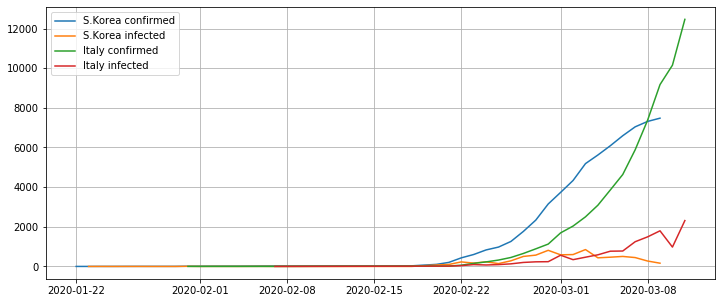

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

korea_df['infected']=korea_df['Confirmed'].diff()
italy_df['infected']=italy_df['Confirmed'].diff()

fig = plt.figure(figsize=(12,5))
plt.plot(korea_df['day'], korea_df['Confirmed'], label = 'S.Korea confirmed')
plt.plot(korea_df['day'], korea_df['infected'], label = 'S.Korea infected')
plt.plot(italy_df['day'], italy_df['Confirmed'], label = 'Italy confirmed') #italy_df plus bas
plt.plot(italy_df['day'], italy_df['infected'], label = 'Italy infected')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
def get_country(self, country):
    return (epidemie_df[epidemie_df['Country/Region'] == country]
            .groupby(['Country/Region','day'])
            .agg({'Confirmed':'sum', 'Deaths':'sum', 'Recovered':'sum'})
            .reset_index()
           )

#Monkey Patch pd.DataFrame
pd.DataFrame.get_country= get_country

In [23]:
get_country(epidemie_df, 'South Korea').head()

,Country/Region,day,Confirmed,Deaths,Recovered
0,South Korea,2020-01-22,1.0,0.0,0.0
1,South Korea,2020-01-23,1.0,0.0,0.0
2,South Korea,2020-01-24,2.0,0.0,0.0
3,South Korea,2020-01-25,2.0,0.0,0.0
4,South Korea,2020-01-26,3.0,0.0,0.0


In [24]:
italy_df = epidemie_df.get_country('Italy')
italy_df.head()

,Country/Region,day,Confirmed,Deaths,Recovered
0,Italy,2020-01-31,2.0,0.0,0.0
1,Italy,2020-02-07,3.0,0.0,0.0
2,Italy,2020-02-21,20.0,1.0,0.0
3,Italy,2020-02-22,62.0,2.0,1.0
4,Italy,2020-02-23,155.0,3.0,2.0


In [27]:
beta,gamma = [0.01,0.1]

def SIR(t,y):
    S = y[0]
    I = y[1]
    R = y[2]
    return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

In [35]:
from scipy.integrate import solve_ivp

beta,gamma = [0.01,0.1]
solution_korea = solve_ivp(SIR, [0, 40], [51_470_000, 1, 0], t_eval=np.arange(0, 40, 1))

In [42]:
def plot_epidemie(solution, infected):
    fig = plt.figure(figsize=(12,5))
    plt.plot(solution.t, solution.y[0])
    plt.plot(solution.t, solution.y[1])
    plt.plot(solution.t, solution.y[2])
    plt.plot(infected.reset_index(drop=True).index, infected, "k*:")
    plt.grid(True)
    plt.legend(['Susceptible','infected', 'Recovered','Original Data'])
    plt.show()

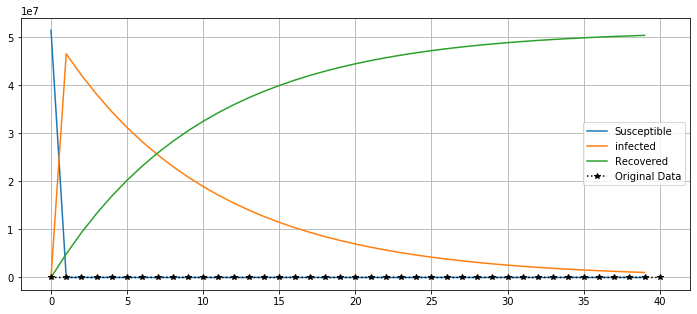

In [43]:
plot_epidemie(solution_korea, korea_df.iloc[2:]['infected'])

In [44]:
korea_df['infected'].max()

851.0

In [46]:
korea_df['infected'].diff().max()

252.0

In [50]:
(korea_df['Recovered'].diff().loc[korea_df['infected'] !=0] / korea_df.loc[korea_df['infected'] !=0]['infected']).mean()

0.17870945831971552

In [51]:
beta,gamma = [0.00000001,0.1]
solution_korea = solve_ivp(SIR, [0, 40], [51_470_000, 1, 0], t_eval=np.arange(0, 41, 1))

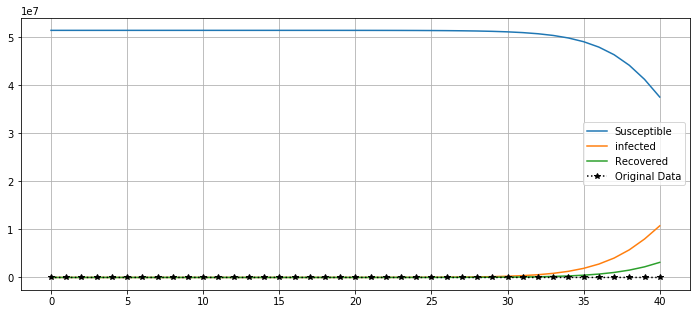

In [55]:
plot_epidemie(solution_korea, korea_df.iloc[2:]['infected'])

In [56]:
solution_korea.y[1][::5]

array([1.00000000e+00, 7.95337875e+00, 6.32150334e+01, 5.02900700e+02,
       3.99302069e+03, 3.17474769e+04, 2.50655705e+05, 1.89396245e+06,
       1.07484823e+07])

In [82]:
def sumsq_error(parameters):
    beta, gamma = parameters

    def SIR(t,y):
        S = y[0]
        I = y[1]
        R = y[2]
        return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

    solution = solve_ivp(SIR, [0, nb_steps-1], [total_population, 1, 0], t_eval=np.arange(0, nb_steps, 1))
    return(sum((solution.y[1]-infected_population)**2))

In [83]:
total_population = 51_470_000

infected_population = korea_df[2:]['infected']
nb_steps=len(infected_population)

In [84]:
len(infected_population)

41

In [85]:
%%time
from scipy.optimize import minimize 

msol = minimize(sumsq_error, [0.001, 0.1], method='Nelder-Mead')
msol.x

Wall time: 10min 40s


array([ 0.06321101, 33.06340503])